### Lasso Feature Selection on Non-Linear Transformations: PCA

In [8]:
import pandas as pd
from sklearn.decomposition import KernelPCA
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import skewtest
from sklearn.linear_model import Lasso
%matplotlib inline

#### Read in data and pre-process variables

In [9]:
df = pd.read_csv("data/Series3_6.15.17_padel.csv")
# Drop examples without IC50
df = df[~df.IC50.isnull()]

# Column types and counts
np.unique(df.dtypes)
len(df.columns[df.iloc[:, :].dtypes == 'O'])
len(df.columns[df.iloc[:, :].dtypes == 'int64'])
len(df.columns[df.iloc[:, :].dtypes == 'float64'])

""" Preprocessing Variables """
# Categorical Variables: No missing values
sum(df[df.columns[df.iloc[:, :].dtypes == 'int64']].isnull().sum())
# Get dummy vars: filter to int type, convert to object, pass to get_dummies.
cat_vars_df = pd.get_dummies(
    df[df.columns[df.iloc[:, :].dtypes == 'int64']].astype('O'))

# Continuous Variables: 67 columns have missing values
sum(df[df.columns[df.iloc[:, :].dtypes == 'float64']].isnull().sum())
# Impute or remove? (for now remove any columns with nan)
cont_vars_df = df[df.columns[df.iloc[:, :].dtypes == 'float64']].dropna(axis=1)
# Drop target variable
cont_vars_df.drop("IC50", axis=1, inplace=True)

#### Process continuous variables: Add transformations, remove skewed features

In [1]:
def add_transformations(df, feat):
    feature_df = df.loc[:, feat].copy()
    if feature_df.min() > 0:  # Avoid 0 or negative
        df.loc[:, feat + "_log"] = feature_df.apply(np.log)  # log
        df.loc[:, feat + "_log2"] = feature_df.apply(np.log2)  # log2
        df.loc[:, feat + "_log10"] = feature_df.apply(np.log10)  # log10
    df.loc[:, feat + "_cubert"] = feature_df.apply(
        lambda x: np.power(x, 1/3))  # cube root
    df.loc[:, feat + "_sqrt"] = feature_df.apply(np.sqrt)  # square root
    if feature_df.max() < 10:  # Avoid extremely large values
        df.loc[:, feat + "_sq"] = feature_df.apply(np.square)  # square
        df.loc[:, feat + "_cube"] = feature_df.apply(
            lambda x: np.power(x, 3))  # cube
        df.loc[:, feat + "_exp"] = feature_df.apply(np.exp)  # exp
        df.loc[:, feat + "_exp2"] = feature_df.apply(np.exp2)  # exp2
    return df

In [11]:
# Add above transformations for all continuous variables
for feature in cont_vars_df.columns:
    cont_vars_df = add_transformations(cont_vars_df, feature)
# Drop any new columns with NaN due to improper transformation
cont_vars_df.replace([np.inf, -np.inf], np.nan, inplace=True)
cont_vars_df.dropna(axis=1, inplace=True)

In [13]:
# Assume skewed if we can reject the null hypothesis with 95% certainty
# Remove any skewed features after adding transformations
cont_vars_df = cont_vars_df.loc[:, cont_vars_df.apply(
    lambda x: skewtest(x)[1] > .05).values]

In [14]:
# Combine datasets
vars_df = pd.concat([cat_vars_df, cont_vars_df], axis=1)

#### Create function for plotting variable distributions

In [15]:
# Plot to compare skewness before and after a few transformations
def view_density_plot(df: pd.DataFrame, title=None):
    """
    Plot density, mean, and median for single feature
    @param df: Single feature dataframe for plotting
    @param title: String, plot title
    """
    df.plot(kind="density", figsize=(4, 4))
    plt.vlines(df.mean(), ymin=0, ymax=.7, linewidth=5.0, label="mean")
    plt.vlines(df.median(), ymin=0, ymax=.7,
               linewidth=2.0, color="red", label="median")
    plt.legend()
    if title is not None:
        plt.title(title)

In [16]:
print(skewtest(df.loc[:, ["IC50"]]))
print(skewtest(df.loc[:, ["IC50"]].apply(np.log)))

SkewtestResult(statistic=array([1.64694995]), pvalue=array([0.09956833]))
SkewtestResult(statistic=array([-5.42540597]), pvalue=array([5.78229633e-08]))


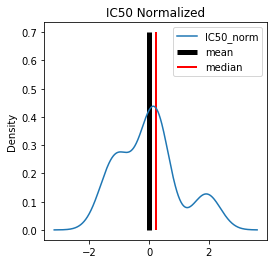

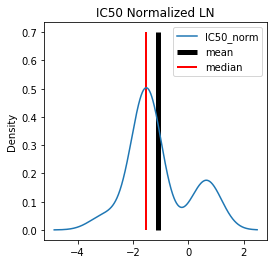

In [17]:
# Analyze target variable for transformations (reciprical and log)
# Normalize target
df.loc[:, "IC50_norm"] = StandardScaler().fit_transform(df.loc[:, ["IC50"]])
view_density_plot(df.loc[:, ["IC50_norm"]], "IC50 Normalized")
view_density_plot(df.loc[:, ["IC50_norm"]].apply(np.log), "IC50 Normalized LN")

Log base 10, log base 2, ln, reciprical don't improve skewness of target variable.

### Perform Lasso feature-selection on entire dataset

In [18]:
# Normalize variables
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(vars_df)
x_columns = list(vars_df.columns)
y_train = y_scaler.fit_transform(df.IC50.values.reshape(-1, 1))

In [19]:
model = Lasso(alpha=0.25, max_iter=100000, tol=1e-5)
model.fit(x_train, y_train)

Lasso(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-05, warm_start=False)

In [20]:
# Extract coefficients
positive_coeffs = len([c for c in model.coef_ if c > 0])
neg_coeffs = len([c for c in model.coef_ if c < 0])
# All non-zero are selected as predictive indicators
pred_indicators = [f for f, c in zip(x_columns, model.coef_) if c != 0]
print("Number of predictors: %s" %len(pred_indicators))

Number of predictors: 21


In [21]:
# Customize color map, darker => more potent
def create_map(x):
    if x < 1:
        return 'black'
    elif x < 10:
        return 'blue'
    elif x < 15:
        return 'deepskyblue'
    else:
        return 'lightgreen'

color_map = df.IC50.apply(create_map)

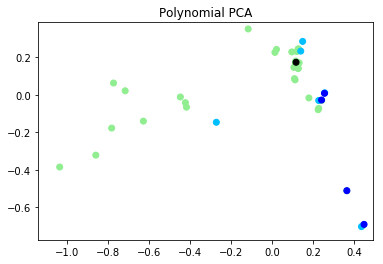

In [22]:
# Build Polynomial Pricipal Components, include all dimensions
pca = KernelPCA(n_components=2, kernel="poly", random_state=0, n_jobs=3)
pca_out = pca.fit_transform(vars_df.loc[:, pred_indicators])

# Sort pca so potent show on top of non-potent (easier visibility)
sorted_pca = [x for (y, x) in sorted(zip(df.IC50.values, pca_out), 
                                     key=lambda pair: pair[0], reverse=True)]
color_map = [x for (y, x) in sorted(zip(df.IC50.values, color_map), 
                                    key=lambda pair: pair[0], reverse=True)]
sorted_pca = np.array(sorted_pca)
x = sorted_pca[:, 0]
y = sorted_pca[:, 1]
plt.scatter(x=x, y=y, c=color_map, alpha=1)
plt.xlim(min(x) * 1.1, max(x) * 1.1)
plt.ylim(min(y) * 1.1, max(y) * 1.1)
plt.title("Polynomial PCA")
plt.show()

In [23]:
print("Features used for PCA " + ", \n".join(pred_indicators))

Features used for PCA nAtom_43, 
nHeavyAtom_27, 
nX_0, 
nBase_0, 
nBase_1, 
C1SP3_1, 
nHssNH_1, 
nssNH_1, 
nsssN_2, 
nHBDon_Lipinski_1, 
MPC2_43, 
MPC3_41, 
MPC10_72, 
nRotB_4, 
WPOL_30, 
WPOL_41, 
Zagreb_146, 
AATSC7c_exp, 
AATSC2i_sqrt, 
AATSC2i_exp2, 
VE1_Dt_exp


An interesting line is forming for the top potency compounds ending with the most potent. 

Thoughts for next steps...
* How well can the features perform in predicting OSM-S-106 potency without having it in train set?
* What is leave-one-out-cv mean-squared-error using these features?
* Replace Lasso selection with forward step-wise feature selection using OSM-S-106 as the validation set
* Refine PCA analysis and color code the missing compounds to identify what could be tested next
* Cross reference the PCA color code recommendation with various predictive methods, is there consistency in the recommendation?

Incorporate decoys into PCA.
Visualize best dimensional split:
  * Pass PCA through feature importance pred algo
  * Visualize using top two dimensions

Improve filtering of features through forward-stepwise selection.
Add decoys to dataset for more detailed separation.

Longer term: genetic algorithm for feature selection?

Kmeans cluster decoys and color code groups along with potency of tested compounds. Differentiate untested compounds. (cluster using the selected features from the best method of feature selection)